In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import glob
import datetime as dt
import multiprocessing as mp
from datetime import datetime
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas import Series
from tqdm import tqdm, tqdm_notebook
import time
import sys
import matplotlib.pyplot as plt




from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection._split import _BaseKFold

from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
cd gdrive/My Drive/TFM/

/content/gdrive/My Drive/TFM


#Loading of already sampled DOLLAR BARS

In [4]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
Dollar_bars = pd.DataFrame()
for i,file in enumerate(glob.glob("data/bars/new_features/*.csv")):
  if i == 0:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i, "files left", end='')
  else:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i, "files left",end='', flush=True)

Percentge of files already Loaded: 0.0 %. There are 1 files left

In [5]:
Dollar_bars.drop(columns=['Unnamed: 0','timestamp.1'],inplace=True)
# timestamp parsing
Dollar_bars['timestamp'] = Dollar_bars.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%d %H:%M:%S.%f"))

Dollar_bars.index = Dollar_bars['timestamp']
Dollar_bars


,timestamp,open,high,low,close,grossValue,homeNotional,foreignNotional,tweet_count,tweet_count2,Google_trend1,Google_trend2
timestamp,,,,,,,,,,,,
2019-12-22 00:00:02.857,2019-12-22 00:00:02.857,126.95,127.60,126.90,127.00,133995088605,75212.579042,9.563766e+06,379.0,172.0,42.0,55.0
2019-12-22 06:51:01.172,2019-12-22 06:51:01.172,127.00,128.80,126.95,128.45,133739653760,74811.562495,9.556766e+06,376.0,204.0,51.0,70.0
2019-12-22 07:42:27.825,2019-12-22 07:42:27.825,128.45,129.50,128.25,129.50,133638036400,74270.069115,9.573891e+06,609.0,359.0,56.0,58.0
2019-12-22 07:57:26.330,2019-12-22 07:57:26.330,129.50,131.45,129.40,130.45,132643814650,73244.938417,9.539001e+06,609.0,359.0,56.0,58.0
2019-12-22 08:02:58.674,2019-12-22 08:02:58.674,130.45,130.55,128.85,129.00,133612879225,73900.574533,9.580523e+06,737.0,211.0,55.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348,2021-05-23 22:32:07.348,2091.35,2115.05,2065.90,2065.95,27670542430,4552.292856,9.452077e+06,3903.0,2226.0,74.0,41.0
2021-05-23 22:50:54.588,2021-05-23 22:50:54.588,2065.95,2075.10,2060.00,2065.00,28421512785,4657.210306,9.631046e+06,3903.0,2226.0,74.0,41.0
2021-05-23 22:53:52.767,2021-05-23 22:53:52.767,2065.00,2104.25,2065.00,2090.00,28385242445,4636.918646,9.626955e+06,3903.0,2226.0,74.0,41.0


#Method and classes definition

##Multiprocessing

In [6]:
class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

##RSI

In [7]:
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

##Bollinger bands

In [8]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

#Volatility, CUSUM filter and triple barrier method

In [53]:
#SNIPPET 3.1 DAILY VOLATILITY ESTIMATES

def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [54]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [55]:
# SNIPPET 3.4 ADDING A VERTICAL BARRIER

def add_vertical_barrier(t_events, close, num_days=5):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

In [56]:
#SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD

def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

In [57]:
# SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH

def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking percentage; 
                  element 1 is stop loss percentage.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events

In [58]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

In [59]:
# SNIPPET 3.5 LABELING FOR SIDE AND SIZE

def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

##MISC

In [60]:
# Compute RSI
def get_rsi(data, window=14):
    df = data
    df.index = list(range(0,len(Dollar_bars)))
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [61]:
def returns(candles_close_prices):
    return pd.Series(np.diff(np.log(candles_close_prices)))

##Average uniqueness, sequential bootstrap and time decay

In [65]:
def getIndMatrix(barIx,t1):
  # Get indicator matrix
  indM=pd.DataFrame(0,index=barIx,columns=range(t1.shape[0]))
  for i,(t0,t1) in enumerate(t1.iteritems()): indM.loc[t0:t1,i]=1.
  return indM



In [66]:
def getAvgUniqueness(indM):
  # Average uniqueness from indicator matrix
  c=indM.sum(axis=1)
  # concurrency
  u=indM.div(c,axis=0) # uniqueness
  avgU=u[u>0].mean() # average uniqueness
  return avgU
  


In [67]:
def seqBootstrap(indM,sLength=None):
  # Generate a sample via sequential bootstrap
  if sLength is None:sLength=indM.shape[1]
  phi=[]
  while len(phi)<sLength:
    avgU=pd.Series()
    for i in indM:
      indM_=indM[phi+[i]] # reduce indM
      avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
    prob=avgU/avgU.sum() # draw prob
    phi+=[np.random.choice(indM.columns,p=prob)]
  return phi 

In [68]:
#SNIPPET 4.1 ESTIMATING THE UNIQUENESS OF A LABEL
def mpNumCoEvents(closeIdx,t1,molecule):
  #Compute the number of concurrent events per bar.
  #+molecule[0] is the date of the first event on which the weight will be computed
  #+molecule[-1] is the date of the last event on which the weight will be computed
  #Any event that starts before t1[molecule].max() impacts the count.
  #1) find events that span the period [molecule[0],molecule[-1]]
  t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
  t1=t1[t1>=molecule[0]] # events that end at or after molecule[0] 
  t1=t1.loc[:t1[molecule].max()]# events that start at or before t1[molecule].max()
  #2) count events spanning a bar
  iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
  count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
  for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
  return count.loc[molecule[0]:t1[molecule].max()]  


In [69]:
#SNIPPET 4.2 ESTIMATING THE AVERAGE UNIQUENESS OF EACH LABEL
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive average uniqueness over the event's lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
      wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght
    #SNIPPET 4.10 DETERMINATION OF SAMPLE WEIGHT BY ABSOLUTE RETURN ATTRIBUTION


In [70]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
      wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()


In [71]:
#SNIPPET 4.11 IMPLEMENTATION OF LINEAR TIME-DECAY FACTORS
def getTimeDecay(tW,clfLastW=1.):
  # apply piecewise-linear decay to observed uniqueness (tW)
  # newest observation gets weight=1, oldest observation gets weight=clfLastW
  # if clfLastW = 1.0 means that there is no time decay.
  # if 0.0 < clfLastW < 1.0 means that weights decay linearly over time,
  #   but every observation still receives a strictly positive weight, regardless of how old.
  # if clfLastW = 0.0 means that weights converge linearly to zero, as they become older.
  # if clfLastW < 0.0 means that the oldest portion cT of the observations receive zero weight
  #(i.e., they are erased from memory).
 clfW=tW.sort_index().cumsum()
 if clfLastW>=0:slope=(1.-clfLastW)/clfW.iloc[-1]
 else:slope=1./((clfLastW+1)*clfW.iloc[-1])
 const=1.-slope*clfW.iloc[-1]
 clfW=const+slope*clfW
 clfW[clfW<0]=0
 print(const,slope)
 return clfW

#Moving average primary model

In [16]:
# fast and slow mavg
# Add fast and slow moving averages
fast_window = 7
slow_window = 15

Dollar_bars['fast_mavg'] = (Dollar_bars['close']
                         .rolling(window=fast_window,
                                  min_periods=fast_window, center=False)
                         .mean())
Dollar_bars['slow_mavg'] = (Dollar_bars['close']
                         .rolling(window=slow_window,
                                  min_periods=slow_window, center=False)
                         .mean())
Dollar_bars['log_ret'] = np.log(Dollar_bars['close']).diff()
Dollar_bars['vol5'] = Dollar_bars['log_ret'].rolling(5).std()
Dollar_bars['vol10'] = Dollar_bars['log_ret'].rolling(10).std()

Dollar_bars['serialcorr20-1'] = Dollar_bars['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=1))

In [17]:
Dollar_bars = Dollar_bars.dropna()
Dollar_bars

,timestamp,open,high,low,close,grossValue,homeNotional,foreignNotional,tweet_count,tweet_count2,Google_trend1,Google_trend2,fast_mavg,slow_mavg,log_ret,vol5,vol10,serialcorr20-1
timestamp,,,,,,,,,,,,,,,,,,
2019-12-23 16:22:31.543,2019-12-23 16:22:31.543,133.05,133.25,131.10,131.65,126414998695,72398.642716,9.569079e+06,878.0,334.0,59.0,61.0,132.492857,132.456667,-0.010578,0.006177,0.007214,-0.082553
2019-12-23 17:00:16.064,2019-12-23 17:00:16.064,131.65,131.90,128.30,129.50,127537872385,73698.307182,9.570333e+06,682.0,560.0,51.0,60.0,132.007143,132.410000,-0.016466,0.008578,0.007120,0.063419
2019-12-23 17:23:15.211,2019-12-23 17:23:15.211,129.50,129.75,128.55,128.85,128932054090,74058.831238,9.568693e+06,682.0,560.0,51.0,60.0,131.592857,132.290000,-0.005032,0.007502,0.007035,0.077690
2019-12-23 18:00:28.708,2019-12-23 18:00:28.708,128.85,129.85,128.60,128.70,129102067430,74092.373850,9.568013e+06,555.0,367.0,50.0,54.0,131.057143,132.093333,-0.001165,0.007358,0.006922,0.162593
2019-12-23 21:07:11.804,2019-12-23 21:07:11.804,128.70,128.70,126.25,126.45,130579920305,75116.914913,9.539316e+06,716.0,332.0,53.0,65.0,130.142857,131.660000,-0.017637,0.007125,0.008094,0.244761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348,2021-05-23 22:32:07.348,2091.35,2115.05,2065.90,2065.95,27670542430,4552.292856,9.452077e+06,3903.0,2226.0,74.0,41.0,2100.328571,2026.223333,-0.012220,0.013460,0.018655,0.225385
2021-05-23 22:50:54.588,2021-05-23 22:50:54.588,2065.95,2075.10,2060.00,2065.00,28421512785,4657.210306,9.631046e+06,3903.0,2226.0,74.0,41.0,2095.435714,2035.420000,-0.000460,0.010153,0.013030,0.172634
2021-05-23 22:53:52.767,2021-05-23 22:53:52.767,2065.00,2104.25,2065.00,2090.00,28385242445,4636.918646,9.626955e+06,3903.0,2226.0,74.0,41.0,2092.950000,2048.086667,0.012034,0.013222,0.012083,0.115326


# **#PRIMARY MODEL**

In [32]:
# compute bands
window = 50

rsi_windows = [5, 13, 34, 55]
for w in rsi_windows:
    rsi = get_rsi(Dollar_bars, window=w).squeeze()
    Dollar_bars[f'rsi_{w}'] = rsi


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
Dollar_bars['avg'], Dollar_bars['upper'], Dollar_bars['lower'] = bbands(Dollar_bars['close'],window, no_of_stdev=1.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
# compute sides

Dollar_bars['side'] = np.nan

long_signals = (Dollar_bars['close'] <= Dollar_bars['lower'])
short_signals = (Dollar_bars['close'] >= Dollar_bars['upper'])
Dollar_bars.loc[long_signals, 'side'] = 1
Dollar_bars.loc[short_signals, 'side'] = -1

print(Dollar_bars.side.value_counts())

# remove Look ahead bias by lagging the signal
Dollar_bars['side'] = Dollar_bars['side'].shift(1)

# drop the NaN values from our data set
Dollar_bars.dropna(axis=0, how='any', inplace=True)  

-1.0    1484
 1.0    1240
Name: side, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

# METALABELING

In [49]:
Dollar_bars.index = Dollar_bars['timestamp']
# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=Dollar_bars['close'], lookback=50)

Calculating daily volatility for dynamic thresholds


In [50]:
aux = returns(Dollar_bars['close'])

Dollar_bars['return'] = np.append([np.nan],aux)

Dollar_bars.dropna(axis=0, how='any', inplace=True)  

Dollar_bars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp,open,high,low,close,grossValue,homeNotional,foreignNotional,tweet_count,tweet_count2,Google_trend1,Google_trend2,fast_mavg,slow_mavg,log_ret,vol5,vol10,serialcorr20-1,rsi_5,rsi_13,rsi_34,rsi_55,side,avg,upper,lower,return
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-29 13:51:24.670,2019-12-29 13:51:24.670,130.70,131.90,130.40,130.65,129772386575,73081.358837,9.581556e+06,735.0,337.0,74.0,65.0,129.450000,128.563333,-0.000383,0.005450,0.005649,0.247469,96.0,86.0,71.0,64.0,-1.0,127.356739,130.465928,124.247551,-0.000383
2019-12-29 15:06:42.910,2019-12-29 15:06:42.910,130.65,132.60,130.65,132.45,125490380775,70357.436255,9.270498e+06,653.0,344.0,70.0,59.0,130.114286,128.916667,0.013683,0.006816,0.006583,0.168287,97.0,88.0,73.0,65.0,-1.0,127.568349,130.980373,124.156326,0.013683
2019-12-29 15:50:41.524,2019-12-29 15:50:41.524,132.45,133.35,131.90,132.85,133317328375,74389.377535,9.856928e+06,653.0,344.0,70.0,59.0,130.778571,129.330000,0.003015,0.006864,0.006470,0.151061,98.0,90.0,75.0,67.0,-1.0,127.787276,131.489824,124.084727,0.003015
2019-12-29 16:10:15.146,2019-12-29 16:10:15.146,132.80,133.85,132.40,132.55,129384792125,71934.217591,9.570627e+06,559.0,360.0,73.0,69.0,131.364286,129.676667,-0.002261,0.006568,0.005434,0.102312,99.0,91.0,76.0,68.0,-1.0,127.984252,131.884260,124.084244,-0.002261
2019-12-29 17:29:42.425,2019-12-29 17:29:42.425,132.55,134.15,132.50,133.60,128903662010,71459.559025,9.535651e+06,499.0,306.0,69.0,69.0,131.957143,130.076667,0.007890,0.006471,0.005446,0.042450,99.0,92.0,77.0,69.0,-1.0,128.216012,132.393567,124.038456,0.007890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 09:14:16.219,2021-05-23 09:14:16.219,2020.25,2097.05,1993.10,2078.60,27729310355,4677.812560,9.578015e+06,4844.0,2332.0,80.0,37.0,2069.350000,2176.810000,0.028424,0.020899,0.015961,-0.154011,34.0,22.0,29.0,33.0,1.0,2273.696169,2500.765092,2046.627246,0.028424
2021-05-23 12:43:18.841,2021-05-23 12:43:18.841,1961.50,1970.00,1926.80,1970.00,28159705955,4898.541377,9.547693e+06,6818.0,3362.0,76.0,38.0,2063.800000,2068.040000,0.004324,0.019874,0.021544,0.173051,5.0,17.0,27.0,31.0,1.0,2202.517565,2443.071840,1961.963289,-0.053661
2021-05-23 12:54:41.821,2021-05-23 12:54:41.821,1919.10,1968.65,1905.05,1943.05,28234395170,4925.769860,9.560860e+06,6818.0,3362.0,76.0,38.0,2006.435714,2055.023333,0.012403,0.024162,0.019150,0.057042,28.0,27.0,31.0,33.0,1.0,2181.663811,2437.453709,1925.873913,-0.013775


In [51]:
close = Dollar_bars['close']

# creating our event triggers using the CUSUM filter 

cusum_events = get_t_events(Dollar_bars['close'], threshold=daily_vol.mean())

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=2)

# determining timestamps of first touch   

pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 5% 

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=Dollar_bars['side']
                                   )

Applying Symmetric CUSUM filter.


100%|██████████| 2715/2715 [00:00<00:00, 13416.02it/s]
2021-12-14 12:14:43.520302 100.0% apply_pt_sl_on_t1 done after 0.01 minutes. Remaining 0.0 minutes.


In [52]:
labels = get_bins(triple_barrier_events, Dollar_bars['close'])
labels.side.value_counts()  

-1.0    139
 1.0    123
Name: side, dtype: int64

In [ ]:
Dollar_bars_ = Dollar_bars.reset_index()
Dollar_bars['idx'] = Dollar_bars_.index
Dollar_bars_ = Dollar_bars.loc[triple_barrier_events.index]
triple_barrier_events['idx'] = Dollar_bars_['idx']

In [ ]:
prueba = Dollar_bars.loc[triple_barrier_events.t1]
t1_num = pd.Series(data=prueba['idx'])
t1_num.index = triple_barrier_events['idx']


In [ ]:
t11=pd.Series(t1_num.values,index=t1_num.index)
barIx=range(t11.max()+1)

In [ ]:
tryy = getIndMatrix(barIx,t11)

In [ ]:
getAvgUniqueness(tryy)

0     1.000000
1     0.958333
2     0.875000
3     0.509804
4     0.456667
5     0.442982
6     0.312500
7     0.680556
8     0.666667
9     0.857143
10    0.923077
11    0.833333
12    0.833333
13    0.875000
14    0.750000
15    0.888889
16    0.857143
17    0.772727
18    0.611111
19    0.476190
20    0.768519
21    0.739583
22    0.444444
23    0.916667
24    0.857143
25    0.573333
26    0.370370
27    0.471014
28    0.533333
29    0.480392
30    0.461538
31    0.575758
32    0.696078
33    0.476190
34    0.698925
35    0.472222
36    0.739316
37    0.750000
38    0.777778
39    0.500000
40    0.970588
dtype: float64

In [ ]:
seqBootstrap(tryy)

In [ ]:
t1=t11 # t0,t1 for each feature obs
#barIx=range(t1.max()+1)
#indM=getIndMatrix(barIx,t1)
indM = tryy
phi=np.random.choice(indM.columns,size=indM.shape[1])
print(phi)
print ('Standard random bootstrap uniqueness:',getAvgUniqueness(indM[phi]).mean())
phi=seqBootstrap(indM)
print(phi)
print('Sequential bootstrap uniqueness:',getAvgUniqueness(indM[phi]).mean())


In [ ]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.37      1.00      0.54        15

    accuracy                           0.37        41
   macro avg       0.18      0.50      0.27        41
weighted avg       0.13      0.37      0.20        41

Confusion Matrix
[[ 0 26]
 [ 0 15]]

Accuracy
0.36585365853658536


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



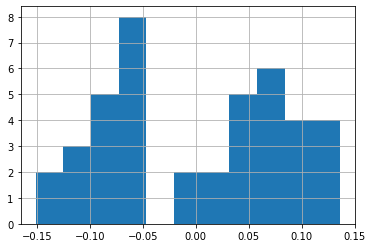

In [ ]:
labels['ret'].hist(bins=11)


1.   Compute a t1 series on dollar bars derived from tick data
2.   Apply the function mpNumCoEvents to compute the number of overlapping
outcomes at each point in time.



In [ ]:
numCoEvents = MultiProcessingFunctions.mp_pandas_obj(func=mpNumCoEvents,
                                                     pd_obj= ('molecule',triple_barrier_events.index),
                                                     num_threads=24,
                                                     closeIdx=close.index,
                                                     t1=triple_barrier_events['t1']
                                                     )

2021-10-28 10:44:18.876901 100.0% mpNumCoEvents done after 0.01 minutes. Remaining 0.0 minutes.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents=numCoEvents.reindex(close.index).fillna(0)

In [ ]:
numCoEvents.value_counts()

1.0    216
2.0    150
3.0     19
0.0     17
4.0      1
dtype: int64

In [ ]:
#labels['stdret'] = labels['ret'].ewm(span=window).std()

In [ ]:
fig = make_subplots(rows=1, cols=1,specs=[[{"secondary_y": True}]])
# Create figure with secondary y-axis

fig.add_trace(go.Scatter(
    x = numCoEvents.index,
    y = numCoEvents,
    #y=labels['ret'].ewm(span=window).std(),
    name="Number of concurrent samples",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )
fig.add_trace(go.Scatter(
    x=labels['ret'].ewm(span=window).std().index,
    y=labels['ret'].ewm(span=window).std(),
    name="exponentially weighted moving standard deviation of returns",
    mode = 'lines',
    textfont_family="Arial_Black"),
    secondary_y=True,
    row= 1 , 
    col= 1 )

In [ ]:
#CALLING SNIPPET 4.2 AVERAGE UNIQUENESS OF EACH LABEL
labels['tW'] = MultiProcessingFunctions.mp_pandas_obj(func= mpSampleTW,
                                                   pd_obj = ('molecule',triple_barrier_events.index),
                                                   num_threads = 24,
                                                   t1 = triple_barrier_events['t1'],
                                                   numCoEvents = numCoEvents)

In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(
    x=labels.index,
    y=labels['tW'],
    name="average uniqueness over the labels lifespan sequentially",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )

In [ ]:
#SAMPLE WEIGHT BY ABSOLUTE RETURN ATTRIBUTION
labels['w'] = MultiProcessingFunctions.mp_pandas_obj(func = mpSampleW,
                                                   pd_obj = ('molecule',triple_barrier_events.index),
#                                                   numThreads = 24,
                                                   t1=triple_barrier_events['t1'],
                                                   numCoEvents=numCoEvents,
                                                   close=Dollar_bars['close'])
labels['w'] *= labels.shape[0]/labels['w'].sum()


In [ ]:
labels

,ret,trgt,bin,side,tW,w,Uniq
2021-06-02 13:29:20.191402,-0.011513,0.009746,0,-1.0,1.000000,0.507966,1.000000
2021-06-04 05:37:04.806399,0.054638,0.048114,1,1.0,0.958333,0.511490,0.958333
2021-06-07 01:01:18.467262,0.086620,0.071964,1,-1.0,0.875000,0.512493,0.875000
2021-06-07 21:13:58.723830,-0.073888,0.069896,0,1.0,0.509804,0.531759,0.509804
2021-06-08 02:51:04.583039,0.016853,0.074381,0,1.0,0.456667,0.543309,0.456667
2021-06-11 01:10:51.317305,0.015172,0.068928,0,1.0,0.442982,0.547053,0.442982
2021-06-12 02:17:10.649007,0.097883,0.061233,1,1.0,0.312500,0.552826,0.312500
2021-06-13 20:09:53.356710,0.075142,0.062135,1,-1.0,0.680556,0.559168,0.680556
2021-06-16 17:04:16.873518,-0.071498,0.068493,0,1.0,0.666667,0.569486,0.666667
2021-06-18 16:06:24.798695,-0.064694,0.064068,0,1.0,0.857143,0.592779,0.857143


In [ ]:
# max_samples is set to the average uniqueness (avgU) between samples.
labels['Uniq'] = getAvgUniqueness(tryy)


#Apply decay factor for sample weights
labels['w'] = getTimeDecay(labels['w'],0.5)

0.5 0.012195121951219511


1. Set a parameter **max_features** to a lower value, as a way of forcing discrepancy between trees.
2. Early stopping: Set the regularization parameter **min_weight_fraction_** leaf to a sufficiently large value (e.g., 5%) such that out-of-bag accuracy converges to out-of-sample (k-fold) accuracy.
3. Use **BaggingClassifier** on **DecisionTreeClassifier** where **max_samples** is set to the average uniqueness (avgU) between samples.


  

>> a).   clf=DecisionTreeClassifier(criterion='entropy',max_features='auto',class_weight='balanced')

>>  b).   bc=BaggingClassifier(base_estimator=clf,n_estimators=
1000,max_samples=avgU,max_features=1.)


4. Use **BaggingClassifier** on **RandomForestClassifier** where max_
samples is set to the average uniqueness (avgU) between samples.

>> clf=RandomForestClassifier(n_estimators=1,criterion= 'entropy',bootstrap=False,class_weight='balanced_ subsample')
>> bc=BaggingClassifier(base_estimator=clf,n_estimators= 1000,max_samples=avgU,max_features=1.)

5. Modify the RF class to replace standard bootstrapping with sequential bootstrapping


In [ ]:
aux_ = getAvgUniqueness(tryy)

aux_.index = labels.index

labels['Uniq'] = aux_

labels


In [ ]:
avgU = labels['Uniq'].mean()

In [ ]:
avgU

0.6793573002509681

In [ ]:
#RANDOM FORESTCLASSIFIER WITH BOOTSTRAP WITH REPLACEMENT(Thats why we dont use a bagging classifier here)
#This version doesn't use IID samples instead each estimator
#we fit N classifiers on the whole dataset
#If a large number of samples are redundant (non-IID), overfitting will still take place:
#Sampling randomly with replacement will build a large number of essentially identical trees (𝜌̄ ≈ 1),
#bagging is only effective to the extent that 𝜌̄ < 1
#class_weight='balanced_subsample' will help you prevent the trees from misclassifying minority classes.
#Unlike bagging, RF always fixes the size of the boot- strapped samples to match the size of the training dataset.

clf0=RandomForestClassifier(n_estimators=1000,class_weight='balanced_subsample', criterion='entropy')

In [ ]:
#RF shares some similarities with bagging, in the sense of training independently individual estimators over bootstrapped subsets of the data.
#The key difference with bagging is that random forests incorporate a second level of randomness: When optimizing each node split,
#only a random subsample (without replacement) of the attributes will be evaluated, with the purpose of further decorrelating the estimators.
#max_samples is set to the average uniqueness (avgU) between samples


clf1=DecisionTreeClassifier(criterion='entropy',max_features='auto', class_weight='balanced')
clf1=BaggingClassifier(base_estimator=clf1,n_estimators=1000,max_samples=avgU)

In [ ]:
#One of the goals of sequential bootstrapping is to produce samples as independent as possible
#thereby reducing 𝜌̄, which should lower the variance of bagging classifiers.
#A low number k(number of classes) is preferred to a high as excessive partitioning would place in the testing set samples too similar to those used in the training set.
#Unlike bagging, RF always fixes the size of the boot- strapped samples to match the size of the training dataset.
#max_samples is set to the average uniqueness (avgU) between samples

clf2=RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap=False,class_weight='balanced_subsample',min_weight_fraction_leaf=0.05)
clf2=BaggingClassifier(base_estimator=clf2,n_estimators=1000,max_samples=avgU,max_features=1.)

In [ ]:
#overwrites full initial dataset
data = Dollar_bars.loc[labels.index, :]
data['cumret'] = ((data['return'] + 1.).cumprod() - 1)

In [ ]:
fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(
    x=data.index,
    y=data['cumret'],
    name="Cumulative returns",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )